# Which Movies Make a Profit?
## CPSC 322 Final Project by Kat Sotelo Jimenez and Ciara Patterson

In this data science project, we investigated the possibility of predicting a film's financial success from features like it's director, writer, IMDb rating, etc. We wanted to understand if some types of films were more financially successful than others. While this analysis is preliminary, one day similar analysis could be used to help studios decide whether they want to invest in a film.

Our EDA demonstrated that movies typically have a higher IMDb rating and higher profit and we believe that is because you have to buy a ticket to make a review. Our EDA also demonsrtated that around 2,000 movies broke even and only a little more than 600 movies made a profit. We also saw that comedy and action movies had made more of a profit. 

The classifications that we implemented are Decision Tree Classifier, Naive Bayes Classifier, and the K Nearest Neighbors Classifier. After initial testing we decided to deploy our KNN classifier because it had the most even class recognition. 

In [4]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils
from mysklearn.myutils import MinMaxScale

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 


import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, ZeroRClassifier, RandomClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myeval
import os

import plot_utils
importlib.reload(plot_utils)
import plot_utils as pu

import math
from collections import Counter
from statistics import median

movies_fname = os.path.join('input_data', 'movies.csv')
movies_table = MyPyTable().load_from_file(movies_fname, encode = 'cp1252')

## Attributes 

The attributes on the dataset are:
* Budget: The budget the movie had. For movies that don’t have any it is 0.
* Company: The production company
* Country: The movies country of origin
* Director: The director of the movie
* Genre: The main genre of the movie:
* Gross: The revenue of the the movie
* Name: The name of the movie
* Rating: The rating of the movie (R, PG, PG-13, etc.)
* Released: The release date(yyyy-mm-dd)
* Runtime: The duration of the movie.
* Score: What IMDb user rating it has.
* Votes: The number of user votes.
* Star: The main actor and actress
* Writer: The writer of the movie
* Year: The year of release. 

The attributes that we will mainly use are budget, director, genre, gross, name, rating, score, votes, star and writer

## Process of cleaning the Votes Data:


In [5]:
# Votes 
votes_col = movies_table.get_column("votes")
unique_votes = myutils.compute_unique_list(votes_col)
# print("Unique Votes:", unique_votes)
max_vote = max(unique_votes)
min_vote = min(unique_votes)
print("MAX:" , max_vote)
print("MIN: ", min_vote)
median_vote = median(unique_votes)
print("MEDIAN:", median_vote)
new_list = [min_vote, median_vote]
new_median = median(new_list)
print("min to median",new_median)
other_list = [median_vote, max_vote]
other_median = median(other_list)
print("median to max: ", other_median)
new_list_ratings = [min_vote, new_median, median_vote, other_median, max_vote]
print(new_list_ratings)

MAX: 1861666.0
MIN:  27.0
MEDIAN: 28054.0
min to median 14040.5
median to max:  944860.0
[27.0, 14040.5, 28054.0, 944860.0, 1861666.0]


## Cleaning the data and handling missing values

### Removing movies where budget = 0
In the original Kaggle dataset, the poster mentions that all movies with missing budget data were recorded as having a budget of 0. We won't be able to tell if the movie made a profit made a profit without knowing its budget, so we will remove this data from the table.

# Create a class label
For the classification task, we would like an equal distribution of classes. From our earlier histogram analysis of the films' gross profits.

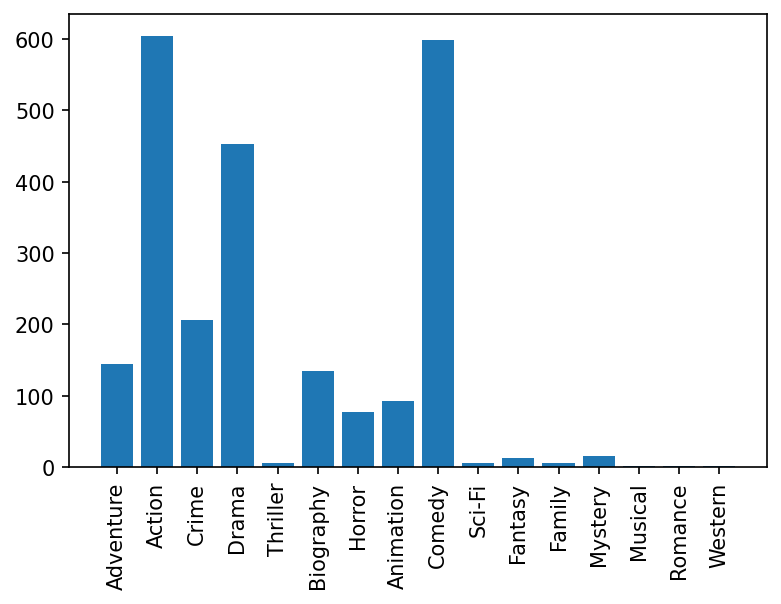

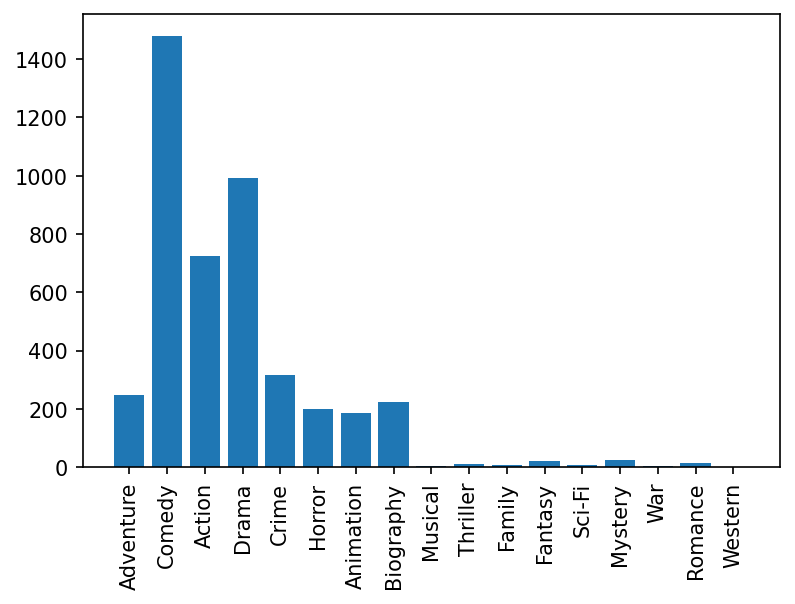

In [6]:
gross_profit = [movies_table.get_column('gross')[i] - movies_table.get_column('budget')[i] for i in range(len(movies_table.data))]
profitted = [0 if gross < 0 else 1 for gross in gross_profit]
movies_table.add_column(profitted, 'profitted')
profit_groups = movies_table.group_by('profitted')
genre_idx = movies_table.column_names.index('genre')
for i in range(2):
    genre_cnt = Counter([x[genre_idx] for x in profit_groups[1][i]])
    pu.plot_bar_chart(labels = genre_cnt.keys(), y = genre_cnt.values())

# Gross Profit
- The grossness of a movie is the total profit minus the budget

## Histogram Analysis 
- Less than 100 movies lost 200,000,000 
- Less than 2,000 movies broke even 
- Less than 500 movies made a profit of 100,000,000
- Less than 100 movies made a profit of 200,000,000


# Relationship between features and budget
If we want to predict a film's success, we first need to understand what features most closely correlate with the gross profit of a film. We can use our prior understanding of what makes a film successful (e.g., high audience rating, high audience engagement) to decide what relationships to investigate.

### IMDb rating and gross profit
This graph demonstrates that the higher the rating the more profit that the film is likely to make.  

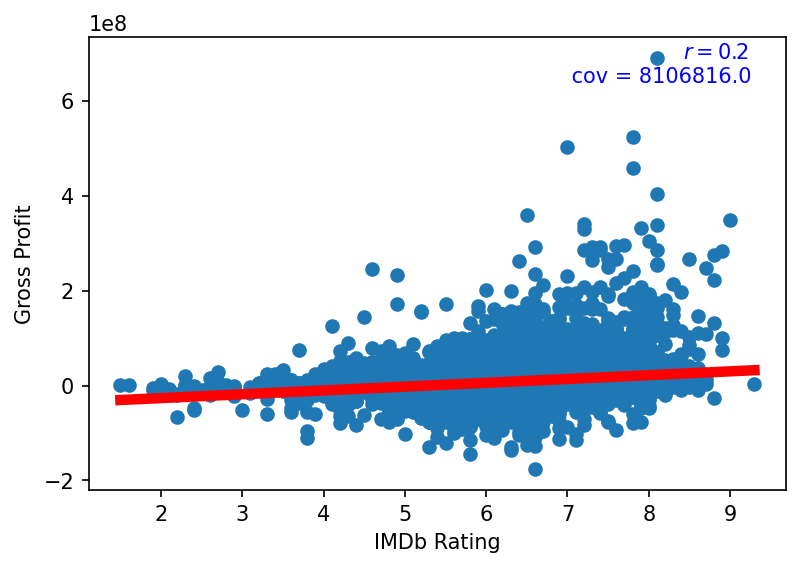

In [7]:
pu.plot_scatterplot(movies_table.get_column('score'), gross_profit, 'IMDb Rating', 'Gross Profit', linear_reg = True, legend_loc = 'upper right')

## Number of votes on IMDb and Gross Profit
This graph demonstrates that the number of audience members that choose to rate the film on IMDb has a correlation with the  profit that the film is likely to make. We can expect this since a person must pay for a ticket or rent the movie online before they give it a rating.

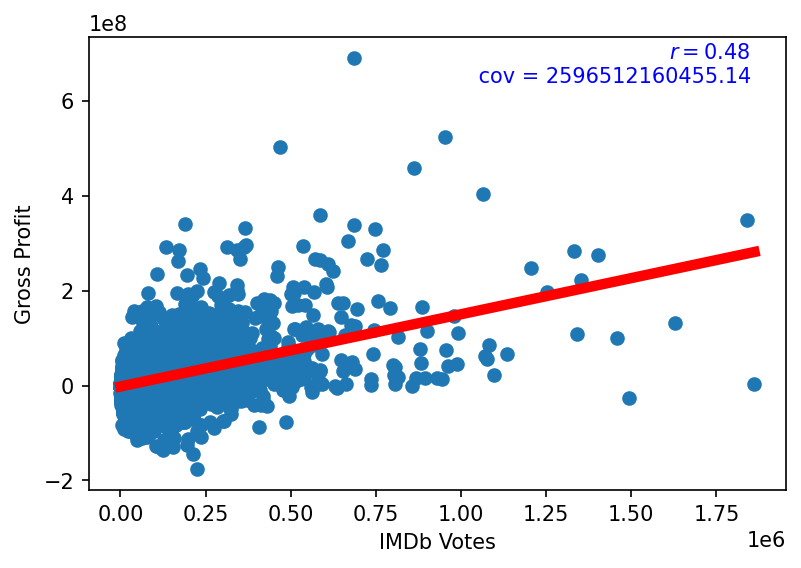

In [8]:
pu.plot_scatterplot(movies_table.get_column('votes'), gross_profit, 'IMDb Votes', 'Gross Profit', linear_reg = True, legend_loc = 'upper right')

# Testing Classifiers on the dataset

Classification Results: This section should describe the classification approach you developed and its performance. Explain what techniques you used, briefly how you designed and implemented the classifiers, how you evaluated your classifiers’ predictive ability, and how well the classifiers performed. Thoroughly describe how you evaluated performance, the comparison results, and which classifier is “best”. Include a link to a Heroku web app with this “best” classifier deployed with an API interface.


In [9]:
def test_folds(k, X_train_folds, X_test_folds, classifier, feature_cols, normalize = False, confusion_matrix = False):
    # evaluation metrics for each fold
    all_preds = []
    actuals = []
    for i in range(k):
        # get features and labels
#         feature_cols = ['budget', 'votes', 'genre', 'rating', 'score', 'star', 'director', 'writer']
        features = movies_table.get_key_columns(feature_cols)
        outcomes = profitted
        
        # get the train and test set for linear_regression
        X_train = [features[j] for j in range(len(features)) if j in X_train_folds[i]]
        y_train = [outcomes[j] for j in range(len(outcomes)) if j in X_train_folds[i]]
        X_test = [features[j] for j in range(len(features)) if j in X_test_folds[i]]
        y_test = [outcomes[j] for j in range(len(outcomes)) if j in X_test_folds[i]]
        
        if normalize:
            # normalize the dataset before fitting the kNN model
            scale = MinMaxScale(X_train, feature_cols)
            scale.get_mins_maxs()
            X_train = scale.normalize(X_train)
            X_test = scale.normalize(X_test)

        # fit the linear regression model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        all_preds.extend(y_pred) # add the predictions
        actuals.extend(y_test) # add the actuals

    if confusion_matrix:
        # print out the confusion matrix for the labels
        labels = list(set(actuals))
        print('Confusion matrix')
        matrix = myeval.confusion_matrix(actuals, all_preds, labels)
        print(myutils.format_confusion_matrix(matrix, labels))
       
        
    else:
        # compute accuracy for the train and test sets
        acc = myutils.compute_accuracy(all_preds, actuals)
        error = myutils.compute_accuracy(all_preds, actuals, error_rate = True)

        print('accuracy = {}, error rate = {}'.format(round(acc, 2), 
                                                                         round(error,2)))
                                                                         
k = 10
X_train_folds_strat, X_test_folds_strat = myeval.stratified_kfold_cross_validation(movies_table.data, 
                                                                                   profitted, n_splits=k)

In [3]:
print('-----------------------------------------------------')
print('K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
knn_class = MyKNeighborsClassifier()
print('Cross Validation Results')
feature_cols = ['budget', 'votes', 'genre', 'rating', 'score', 'star', 'director', 'writer']
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class, feature_cols, normalize = True)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class, feature_cols, normalize = True, confusion_matrix = True)

-----------------------------------------------------
K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------


NameError: name 'MyKNeighborsClassifier' is not defined

# Classifier Results

Out of the 4 classifiers, 3 had very similar results. With the data as is, we were unable to achieve higher than 62% accuracy. We deployed KNN because we can see from the confusion matrix that it had the most even class recognition. 

# Conclusion 

### Summary of Dataset: 

Our dataset was a single CSV file. It contained information about 6,820 movies, having 220 movies each year from the year 1986 to 2016. This data was scraped from IMDb. It contained 15 attributes and we used the grossness of a movie, the budget, genre, rating, score, votes, star, director and writer. We calculated if the movie had a profit based on the grossness of the movie and the budget. If they had made profit we output a 1 and if they didn't it output a 0. We didn't face many challenges with our dataset other than discretizing our data like turning votes into categorical attributes

### Classification approach we developed: 



### Classifiers performance:

The highest classifier we had perform at 62% and two other classifiers Out of the 4 classifiers, 3 had very similar results. We deployed KNN because it had the most even class recongition. To improve performance we could have attempted to descritize our data even more. 
